In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [ ]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_11_modif_top10ventas_nov_v2.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

,CodigoSucursal,CodigoDepartamento,CodigoEstado,TipoMovimiento,DescripcionMovimiento,NumeroMovimiento,NumeroCorrelativo,FechaMovimiento,NombreProducto,UnidadMedida,CantidadSalida,PesoSalida,MontoBase,PrecioUnitario,CostoUnitario,MontoReferencia,NombreGrupo
0,11,1,AC,SVE,VENTA COMPUTARIZADA,18110999,0,2018-11-06,POLLO SIN MENUDENCIA H-C,KG,0.0000,1.2415,15.1300,10.8580,10.8580,2.1743,FAENEADO
1,11,1,AC,SVE,VENTA COMPUTARIZADA,18110996,0,2018-11-06,CORAZON,KG,0.0000,0.9274,11.5700,11.1250,11.1250,1.6625,FAENEADO
2,11,1,AC,SVE,VENTA COMPUTARIZADA,18110995,0,2018-11-06,POLLO SIN MENUDENCIA H-C,KG,0.0000,23.6785,288.8940,10.8580,10.8580,41.5078,FAENEADO
3,11,1,AC,SVE,VENTA COMPUTARIZADA,18110992,0,2018-11-06,CORAZON,KG,0.0000,0.8927,11.1250,11.1250,11.1250,1.5984,FAENEADO
4,11,1,AC,SVE,VENTA COMPUTARIZADA,18110978,0,2018-11-06,CORAZON,KG,0.0000,2.6700,33.3750,11.1250,11.1250,4.7953,FAENEADO


In [ ]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [ ]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

In [ ]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-117-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


### seleccion del top 1

In [ ]:
# Obtener los nombres de los 10 productos más vendidos
top_10_productos = df_todo.groupby('NombreProducto')['MontoBase'].sum().sort_values(ascending=False).head(10)

# Imprimir los nombres de los productos
print("Nombres de los 10 productos más vendidos:")
print(top_10_productos.index)

# Obtener los días de venta para cada producto
dias_de_venta_por_producto = df_todo.groupby(['NombreProducto', 'FechaMovimiento'])['MontoBase'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.groupby('NombreProducto')['FechaMovimiento'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.rename(columns={'FechaMovimiento': 'DiasDeVenta'})
dias_de_venta_por_producto = dias_de_venta_por_producto.sort_values(by='DiasDeVenta', ascending=False).reset_index(drop=True)

# Imprimir los días de venta para cada producto
print("\nDías de venta para cada producto:")
print(dias_de_venta_por_producto)

# Seleccionar el nombre del primer producto
nombre_primer_producto = top_10_productos.index[0]

# Crear un DataFrame solo con las ventas del primer producto y un registro por día
df_top_1 = df_todo[df_todo['NombreProducto'] == nombre_primer_producto].groupby(['FechaMovimiento', 'NombreProducto']).sum().reset_index()

# Imprimir el DataFrame df_top_1
print("\nDataFrame df_top_1:")
print(df_top_1)

Nombres de los 10 productos más vendidos:
Index(['POLLO SIN MENUDENCIA H-C', 'PIERNA MUSLO', 'CORAZON', 'PECHUGA',
       'CUELLO', 'RABADILLA', 'HIGADO', 'MENUDENCIA',
       'SACHET MORTADELA DE POLLO 200 GRS', 'PATE GRANDE 200G'],
      dtype='object', name='NombreProducto')

Días de venta para cada producto:
                      NombreProducto  DiasDeVenta
0           POLLO SIN MENUDENCIA H-C         1711
1                             CUELLO         1577
2                             HIGADO         1458
3                            CORAZON         1360
4                         MENUDENCIA         1346
5                       PIERNA MUSLO         1346
6                            PECHUGA         1312
7                          RABADILLA         1307
8                   PATE GRANDE 200G          918
9  SACHET MORTADELA DE POLLO 200 GRS          886

DataFrame df_top_1:
     FechaMovimiento            NombreProducto  MontoBase    year
0         2018-11-03  POLLO SIN MENUDENCIA H-C  7

In [ ]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_top_1[(df_top_1['FechaMovimiento'] >= '2023-11-01') & (df_top_1['FechaMovimiento'] <= '2023-11-30')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_top_1[df_top_1['FechaMovimiento'] < '2023-11-01']

df_top_1 = df_top_1[df_top_1['FechaMovimiento'] < '2023-12-01']

In [ ]:
print("todo ", df_todo.shape)
print("sin noviembre ", df_todo_hasta_nov.shape)
print("noviembre 2023 ", df_noviembre.shape)

todo  (279990, 4)
sin noviembre  (1677, 4)
noviembre 2023  (30, 4)


In [ ]:
#df_noviembre.head()
print(df_top_1)

     FechaMovimiento            NombreProducto  MontoBase    year
0         2018-11-03  POLLO SIN MENUDENCIA H-C  7795.8660  308754
1         2018-11-04  POLLO SIN MENUDENCIA H-C  5278.5900  226016
2         2018-11-05  POLLO SIN MENUDENCIA H-C  5096.8520  264358
3         2018-11-06  POLLO SIN MENUDENCIA H-C  3420.9820  121080
4         2018-11-07  POLLO SIN MENUDENCIA H-C  3968.6880  201800
...              ...                       ...        ...     ...
1702      2023-11-26  POLLO SIN MENUDENCIA H-C  5866.7376  119357
1703      2023-11-27  POLLO SIN MENUDENCIA H-C  2640.2740   64736
1704      2023-11-28  POLLO SIN MENUDENCIA H-C  5156.1705  210392
1705      2023-11-29  POLLO SIN MENUDENCIA H-C  5654.8998  228599
1706      2023-11-30  POLLO SIN MENUDENCIA H-C  6546.1102  192185

[1707 rows x 4 columns]


In [ ]:
df_noviembre.tail()

,FechaMovimiento,NombreProducto,MontoBase,year
1702,2023-11-26,POLLO SIN MENUDENCIA H-C,5866.7376,119357
1703,2023-11-27,POLLO SIN MENUDENCIA H-C,2640.2740,64736
1704,2023-11-28,POLLO SIN MENUDENCIA H-C,5156.1705,210392
1705,2023-11-29,POLLO SIN MENUDENCIA H-C,5654.8998,228599
1706,2023-11-30,POLLO SIN MENUDENCIA H-C,6546.1102,192185


In [ ]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
print("\n\n")

In [ ]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'NombreProducto',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_desde_2021 = df_noviembre_sumaT.copy()

  FechaMovimiento  MontoBase
0      2023-11-01  3239.2974
1      2023-11-02  7098.1327
2      2023-11-03  4978.8291
3      2023-11-04  4431.8618
4      2023-11-05  4541.8035
5      2023-11-06  7492.0734
6      2023-11-07  7305.7163
7      2023-11-08  4343.5560
8      2023-11-09  3487.1891
9      2023-11-10  1528.0410
FechaMovimiento    datetime64[ns]
MontoBase                 float64
dtype: object
(30, 2)


# PROPHET


### Preparado de los DataFrame

In [ ]:
## Sumar las ventas por día en df_noviembre
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
# se suman todas las ventas por dia
df_noviembre_prophet = df_noviembre.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

df_noviembre_prophet = df_noviembre_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo_hasta_nov_prophet = df_todo_hasta_nov_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)
print("----Prophet----")
print(df_noviembre_prophet.head)
print(df_noviembre_prophet.dtypes)
print(df_todo_hasta_nov_prophet.head)
print(df_todo_hasta_nov_prophet.dtypes)

<bound method NDFrame.head of      FechaMovimiento            NombreProducto  MontoBase    year
1677      2023-11-01  POLLO SIN MENUDENCIA H-C  3239.2974   93058
1678      2023-11-02  POLLO SIN MENUDENCIA H-C  7098.1327  105196
1679      2023-11-03  POLLO SIN MENUDENCIA H-C  4978.8291  167909
1680      2023-11-04  POLLO SIN MENUDENCIA H-C  4431.8618  127449
1681      2023-11-05  POLLO SIN MENUDENCIA H-C  4541.8035  135541
1682      2023-11-06  POLLO SIN MENUDENCIA H-C  7492.0734  315588
1683      2023-11-07  POLLO SIN MENUDENCIA H-C  7305.7163  230622
1684      2023-11-08  POLLO SIN MENUDENCIA H-C  4343.5560  167909
1685      2023-11-09  POLLO SIN MENUDENCIA H-C  3487.1891   97104
1686      2023-11-10  POLLO SIN MENUDENCIA H-C  1528.0410   22253
1687      2023-11-11  POLLO SIN MENUDENCIA H-C  7330.7520  252875
1688      2023-11-12  POLLO SIN MENUDENCIA H-C  4889.5888  121380
1689      2023-11-13  POLLO SIN MENUDENCIA H-C  7760.8445  269059
1690      2023-11-14  POLLO SIN MENUDENCIA H-C

In [ ]:
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])

df_todo_hasta_nov_desde_2021 = df_todo_hasta_nov[~(df_todo_hasta_nov['FechaMovimiento'].dt.year < 2021)]

print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov_desde_2021.head())
print(df_todo_hasta_nov_desde_2021.dtypes)

# se devuelve el tipo object a ds para prophet
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
df_todo_hasta_nov_desde_2021['FechaMovimiento'] = df_todo_hasta_nov_desde_2021['FechaMovimiento'].dt.date

print("---" *10)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print(df_todo_hasta_nov_desde_2021.head())
print(df_todo_hasta_nov_desde_2021.dtypes)
print(df_todo_hasta_nov_desde_2021.shape)

FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                 int64
dtype: object
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
year                        int64
dtype: object
    FechaMovimiento            NombreProducto  MontoBase    year
681      2021-01-02  POLLO SIN MENUDENCIA H-C 10510.9000  353675
682      2021-01-03  POLLO SIN MENUDENCIA H-C  4100.4080   97008
683      2021-01-04  POLLO SIN MENUDENCIA H-C  4341.8650  147533
684      2021-01-05  POLLO SIN MENUDENCIA H-C  4555.7320  194016
685      2021-01-06  POLLO SIN MENUDENCIA H-C  6008.0340  224331
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
year                        int64
dtype: object
------------------------------
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                 int64
dtype: object
FechaMovimiento     object
NombrePr

<ipython-input-126-d6719813a328>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo_hasta_nov_desde_2021['FechaMovimiento'] = df_todo_hasta_nov_desde_2021['FechaMovimiento'].dt.date


In [ ]:
# #primero cambiamos la columna ds a datatime
# df_noviembre['ds'] = pd.to_datetime(df_noviembre['ds'])
# df_todo_hasta_nov['ds'] = pd.to_datetime(df_todo_hasta_nov['ds'])
# # se quitan las horas de la columna de tiempo
# df_noviembre['ds'] = df_noviembre['ds'].dt.date
# df_todo_hasta_nov['ds'] = df_todo_hasta_nov['ds'].dt.date
# se suman todas las ventas por dia

df_todo_hasta_nov_desde_2021_prophet = df_todo_hasta_nov_desde_2021.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_desde_2021_prophet = df_todo_hasta_nov_desde_2021_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_todo_hasta_nov_desde_2021_prophet.head)
print(df_todo_hasta_nov_desde_2021_prophet.shape)

<bound method NDFrame.head of              ds          y
0    2021-01-02 10510.9000
1    2021-01-03  4100.4080
2    2021-01-04  4341.8650
3    2021-01-05  4555.7320
4    2021-01-06  6008.0340
..          ...        ...
991  2023-10-27  6026.4036
992  2023-10-28  5949.4542
993  2023-10-29   374.6544
994  2023-10-30 12163.1227
995  2023-10-31  7254.2832

[996 rows x 2 columns]>
(996, 2)


## Predicciones con todos los datos y desde 2021 del producto top 1

este producto esta en el dataframe df_top_1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdfjedpk_/cn0r9qma.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdfjedpk_/bcw_ktzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98798', 'data', 'file=/tmp/tmpdfjedpk_/cn0r9qma.json', 'init=/tmp/tmpdfjedpk_/bcw_ktzt.json', 'output', 'file=/tmp/tmpdfjedpk_/prophet_model127zkrej/prophet_model-20240301024513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:45:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:45:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf

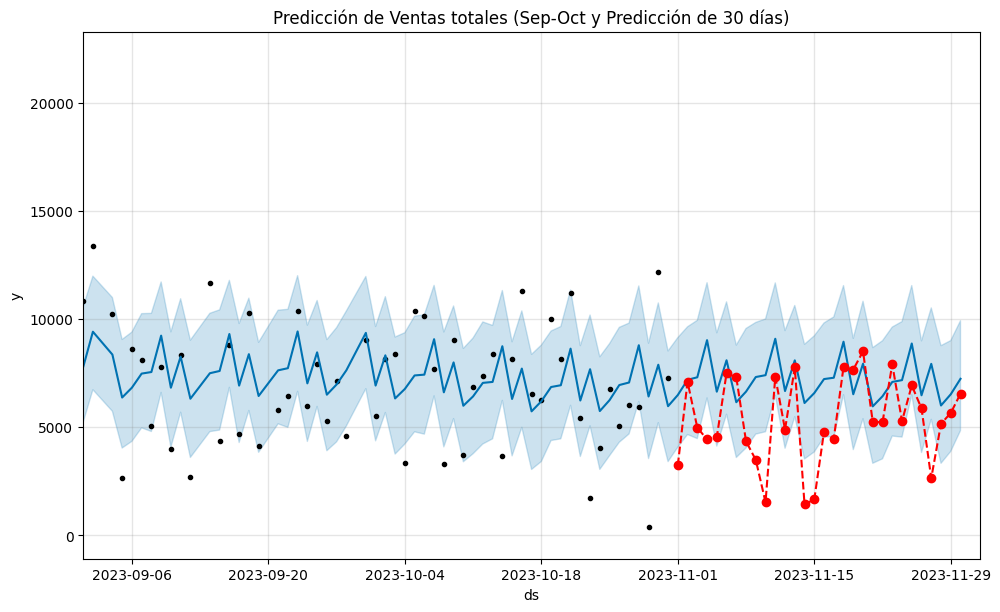

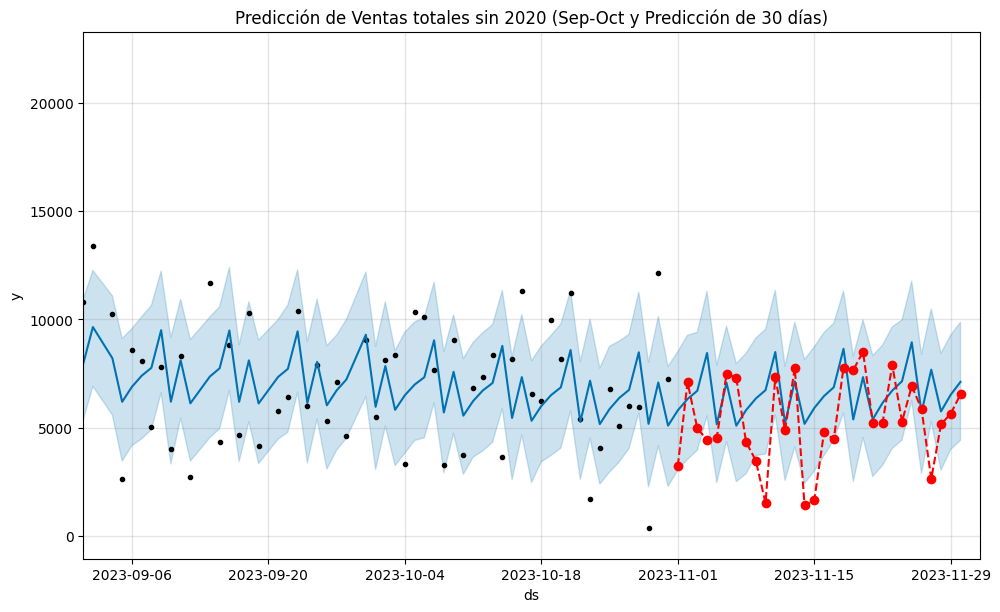

prediccion con todos los valores               ds      yhat
1677 2023-11-01 6485.2545
1678 2023-11-02 7188.6803
1679 2023-11-03 7305.5927
1680 2023-11-04 9022.4054
1681 2023-11-05 6640.3463
1682 2023-11-06 8092.2669
1683 2023-11-07 6153.2595
1684 2023-11-08 6643.6777
1685 2023-11-09 7317.8101
1686 2023-11-10 7402.8683
1687 2023-11-11 9086.1642
1688 2023-11-12 6669.8792
1689 2023-11-13 8087.8522
1690 2023-11-14 6116.1741
1691 2023-11-15 6576.1850
1692 2023-11-16 7223.1241
1693 2023-11-17 7285.0954
1694 2023-11-18 8950.2221
1695 2023-11-19 6521.3960
1696 2023-11-20 7933.0468
1697 2023-11-21 5961.7202
1698 2023-11-22 6429.0620
1699 2023-11-23 7090.4579
1700 2023-11-24 7173.9925
1701 2023-11-25 8867.6006
1702 2023-11-26 6473.8177
1703 2023-11-27 7926.5531
1704 2023-11-28 6001.6769
1705 2023-11-29 6520.0158
1706 2023-11-30 7236.0079
prediccion sin el 2020               ds      yhat
996  2023-11-01 5803.8489
997  2023-11-02 6328.3784
998  2023-11-03 6706.0904
999  2023-11-04 8452.3440
1000 2

In [ ]:
# definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'
# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# Crear un modelo de Prophet
modelo1 = Prophet()
modelo2 = Prophet()
# Ajustar el modelo con los datos de entrenamiento
modelo1.fit(df_todo_hasta_nov_prophet)
modelo2.fit(df_todo_hasta_nov_desde_2021_prophet)
# Crear un DataFrame con fechas futuras para hacer la predicción
futuro1 = modelo1.make_future_dataframe(periods=30)
futuro2 = modelo2.make_future_dataframe(periods=30)
# Hacer la predicción
prediccion1 = modelo1.predict(futuro1)
prediccion2 = modelo2.predict(futuro2)

# Visualizar la predicción con límites ajustados
fig = modelo1.plot(prediccion1)

plt.plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')

# Aplicar límites al eje x
plt.xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
plt.title(f'Predicción de Ventas totales (Sep-Oct y Predicción de 30 días)')
# Mostrar el gráfico
plt.show()

# Visualizar la predicción con límites ajustados
fig = modelo2.plot(prediccion2)

plt.plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')

# Aplicar límites al eje x
plt.xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
plt.title(f'Predicción de Ventas totales sin 2020 (Sep-Oct y Predicción de 30 días)')
# Mostrar el gráfico
plt.show()


# Extraer los valores reales de predicción para cada día
valores_prediccion1 = prediccion1[['ds', 'yhat']].tail(30)
valores_prediccion2 = prediccion2[['ds', 'yhat']].tail(30)

# Mostrar el DataFrame con los valores de predicción
print("prediccion con todos los valores " , valores_prediccion1)
print("prediccion sin el 2020 " , valores_prediccion2)
# # Visualizar la predicción
# fig = modelo1.plot(prediccion1)
# plt.show()

# fig = modelo2.plot(prediccion2)
# plt.show()

## EVALUACION

evaluacion con todos los datos


In [ ]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_desde_2021 = df_noviembre_sumaT.copy()

  FechaMovimiento  MontoBase
0      2023-11-01  3239.2974
1      2023-11-02  7098.1327
2      2023-11-03  4978.8291
3      2023-11-04  4431.8618
4      2023-11-05  4541.8035
5      2023-11-06  7492.0734
6      2023-11-07  7305.7163
7      2023-11-08  4343.5560
8      2023-11-09  3487.1891
9      2023-11-10  1528.0410
FechaMovimiento     object
MontoBase          float64
dtype: object
(30, 2)


In [ ]:
# print(valores_prediccion1.describe)
# print(df_noviembre_sumaT.shape)
df_noviembre_sumaT.tail()

,FechaMovimiento,MontoBase
25,2023-11-26,5866.7376
26,2023-11-27,2640.2740
27,2023-11-28,5156.1705
28,2023-11-29,5654.8998
29,2023-11-30,6546.1102


In [ ]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_sumaT['FechaMovimiento'] = pd.to_datetime(df_noviembre_sumaT['FechaMovimiento'])
valores_prediccion1['ds'] = pd.to_datetime(valores_prediccion1['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_sumaT = pd.merge(df_noviembre_sumaT, valores_prediccion1[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_sumaT.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_sumaT.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_sumaT.head(50))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  3239.2974       6485.2545
1       2023-11-02  7098.1327       7188.6803
2       2023-11-03  4978.8291       7305.5927
3       2023-11-04  4431.8618       9022.4054
4       2023-11-05  4541.8035       6640.3463
5       2023-11-06  7492.0734       8092.2669
6       2023-11-07  7305.7163       6153.2595
7       2023-11-08  4343.5560       6643.6777
8       2023-11-09  3487.1891       7317.8101
9       2023-11-10  1528.0410       7402.8683
10      2023-11-11  7330.7520       9086.1642
11      2023-11-12  4889.5888       6669.8792
12      2023-11-13  7760.8445       8087.8522
13      2023-11-14  1427.7825       6116.1741
14      2023-11-15  1659.6720       6576.1850
15      2023-11-16  4789.3392       7223.1241
16      2023-11-17  4469.1706       7285.0954
17      2023-11-18  7775.5295       8950.2221
18      2023-11-19  7662.2770       6521.3960
19      2023-11-20  8504.3950       7933.0468
20      2023-11-21  5242.8209     

In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])

Evaluation metric results:-
MSE is : 6906389.822842958
MAE is : 2085.786700092378
R2 is : -0.7852525529134227 %
------------------------------
RMSE is : 2628.0011078466005
MAPE is : 69.07964582820276 %
------------------------------


evaluacion sin 2020

In [ ]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_desde_2021['FechaMovimiento'] = pd.to_datetime(df_noviembre_desde_2021['FechaMovimiento'])
valores_prediccion2['ds'] = pd.to_datetime(valores_prediccion2['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_desde_2021 = pd.merge(df_noviembre_desde_2021, valores_prediccion2[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_desde_2021.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_desde_2021.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_desde_2021.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  3239.2974       5803.8489
1       2023-11-02  7098.1327       6328.3784
2       2023-11-03  4978.8291       6706.0904
3       2023-11-04  4431.8618       8452.3440
4       2023-11-05  4541.8035       5158.0573
5       2023-11-06  7492.0734       7077.3262
6       2023-11-07  7305.7163       5095.7510
7       2023-11-08  4343.5560       5811.9786
8       2023-11-09  3487.1891       6347.2257
9       2023-11-10  1528.0410       6736.2389
10      2023-11-11  7330.7520       8494.4891
11      2023-11-12  4889.5888       5212.9944
12      2023-11-13  7760.8445       7145.9362
13      2023-11-14  1427.7825       5178.9819
14      2023-11-15  1659.6720       5910.8242
15      2023-11-16  4789.3392       6462.7024
16      2023-11-17  4469.1706       6869.3593
17      2023-11-18  7775.5295       8646.2342
18      2023-11-19  7662.2770       5384.2844
19      2023-11-20  8504.3950       7337.6003


In [ ]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_PROPHET'])

Evaluation metric results:-
MSE is : 5192538.354675164
MAE is : 1791.1622410751704
R2 is : -0.3422341616345057 %
------------------------------
RMSE is : 2278.7141888958263
MAPE is : 58.11170520981167 %
------------------------------


# LSTM


In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
print(df_todo_hasta_nov.head())
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print("---"*5, "  PROPHET  ", "---"*5)
print(df_todo_hasta_nov_prophet.head())
print(df_todo_hasta_nov_prophet.dtypes)
print(df_todo_hasta_nov_prophet.shape)

  FechaMovimiento            NombreProducto  MontoBase    year
0      2018-11-03  POLLO SIN MENUDENCIA H-C  7795.8660  308754
1      2018-11-04  POLLO SIN MENUDENCIA H-C  5278.5900  226016
2      2018-11-05  POLLO SIN MENUDENCIA H-C  5096.8520  264358
3      2018-11-06  POLLO SIN MENUDENCIA H-C  3420.9820  121080
4      2018-11-07  POLLO SIN MENUDENCIA H-C  3968.6880  201800
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                 int64
dtype: object
(1677, 4)
---------------   PROPHET   ---------------
           ds         y
0  2018-11-03 7795.8660
1  2018-11-04 5278.5900
2  2018-11-05 5096.8520
3  2018-11-06 3420.9820
4  2018-11-07 3968.6880
ds     object
y     float64
dtype: object
(1677, 2)


In [ ]:
df_lstm = df_todo_hasta_nov_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })

df_lstm_desde_2021 = df_todo_hasta_nov_desde_2021_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })

In [ ]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm = df_lstm[['FechaMovimiento', 'MontoBase']]
df_lstm['FechaMovimiento'] = pd.to_datetime(df_lstm['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm.set_index('FechaMovimiento', inplace=True)

# Preprocesamiento de fechas utilizando el índice
df_lstm['DayOW'] = df_lstm.index.dayofweek
df_lstm['Month'] = df_lstm.index.month
df_lstm['Year'] = df_lstm.index.year

# Ordenar el DataFrame por la fecha
df_lstm.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm)

                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-03       7795.8660      5     11  2018
2018-11-04       5278.5900      6     11  2018
2018-11-05       5096.8520      0     11  2018
2018-11-06       3420.9820      1     11  2018
2018-11-07       3968.6880      2     11  2018
...                    ...    ...    ...   ...
2023-10-27       6026.4036      4     10  2023
2023-10-28       5949.4542      5     10  2023
2023-10-29        374.6544      6     10  2023
2023-10-30      12163.1227      0     10  2023
2023-10-31       7254.2832      1     10  2023

[1677 rows x 4 columns]


In [ ]:
print(df_lstm)
print(df_lstm.dtypes)
print(df_todo_hasta_nov_prophet)
print(df_todo_hasta_nov_prophet.dtypes)

                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-03       7795.8660      5     11  2018
2018-11-04       5278.5900      6     11  2018
2018-11-05       5096.8520      0     11  2018
2018-11-06       3420.9820      1     11  2018
2018-11-07       3968.6880      2     11  2018
...                    ...    ...    ...   ...
2023-10-27       6026.4036      4     10  2023
2023-10-28       5949.4542      5     10  2023
2023-10-29        374.6544      6     10  2023
2023-10-30      12163.1227      0     10  2023
2023-10-31       7254.2832      1     10  2023

[1677 rows x 4 columns]
MontoBase    float64
DayOW          int64
Month          int64
Year           int64
dtype: object
              ds          y
0     2018-11-03  7795.8660
1     2018-11-04  5278.5900
2     2018-11-05  5096.8520
3     2018-11-06  3420.9820
4     2018-11-07  3968.6880
...          ...        ...
1672  2023-10-27  6026.4036
1673  2023-10-28  5949.4542
1674  2023-10-

In [ ]:
df_lstm.describe()
#df_lstm.head

,MontoBase,DayOW,Month,Year
count,1677.0000,1677.0000,1677.0000,1677.0000
mean,7047.6205,2.8945,6.5641,2020.8861
std,2735.9453,1.9657,3.5051,1.4889
min,24.9200,0.0000,1.0000,2018.0000
25%,5196.4430,1.0000,3.0000,2020.0000
50%,6932.6639,3.0000,7.0000,2021.0000
75%,8593.5997,5.0000,10.0000,2022.0000
max,22160.3236,6.0000,12.0000,2023.0000


In [ ]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm['MontoBase_scaler'] = scaler.fit_transform(df_lstm['MontoBase'].values.reshape(-1, 1))

# Crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        #label = data[i+seq_length-1]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences(df_lstm['MontoBase_scaler'].values, seq_length)


dividir en entrenamiento y al final toda la prueba

In [ ]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dividir en periodos de testeo en medio de la serie temporal

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(n_splits=5)  # Puedes ajustar el número de divisiones

# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

In [ ]:
# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Desnormalizar las predicciones
predictions = scaler.inverse_transform(predictions)


Epoch 1/50
42/42 - 3s - loss: 0.0320 - 3s/epoch - 75ms/step
Epoch 2/50
42/42 - 1s - loss: 0.0097 - 763ms/epoch - 18ms/step
Epoch 3/50
42/42 - 1s - loss: 0.0093 - 775ms/epoch - 18ms/step
Epoch 4/50
42/42 - 1s - loss: 0.0092 - 585ms/epoch - 14ms/step
Epoch 5/50
42/42 - 0s - loss: 0.0092 - 485ms/epoch - 12ms/step
Epoch 6/50
42/42 - 0s - loss: 0.0092 - 475ms/epoch - 11ms/step
Epoch 7/50
42/42 - 0s - loss: 0.0091 - 493ms/epoch - 12ms/step
Epoch 8/50
42/42 - 0s - loss: 0.0091 - 466ms/epoch - 11ms/step
Epoch 9/50
42/42 - 0s - loss: 0.0090 - 478ms/epoch - 11ms/step
Epoch 10/50
42/42 - 0s - loss: 0.0090 - 476ms/epoch - 11ms/step
Epoch 11/50
42/42 - 0s - loss: 0.0090 - 472ms/epoch - 11ms/step
Epoch 12/50
42/42 - 0s - loss: 0.0090 - 482ms/epoch - 11ms/step
Epoch 13/50
42/42 - 0s - loss: 0.0092 - 466ms/epoch - 11ms/step
Epoch 14/50
42/42 - 0s - loss: 0.0091 - 480ms/epoch - 11ms/step
Epoch 15/50
42/42 - 0s - loss: 0.0090 - 468ms/epoch - 11ms/step
Epoch 16/50
42/42 - 0s - loss: 0.0090 - 470ms/epoch 

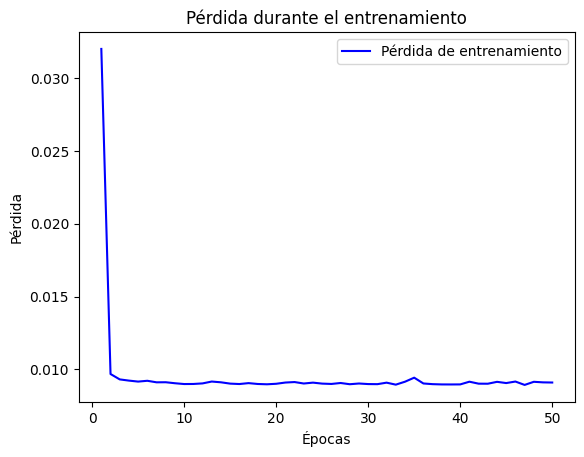

In [ ]:
# Recuperar la función de pérdida durante el entrenamiento
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Graficar la pérdida durante el entrenamiento
plt.plot(epochs, loss, 'b', label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Error cuadrático medio en el conjunto de prueba: 8300238.978995982


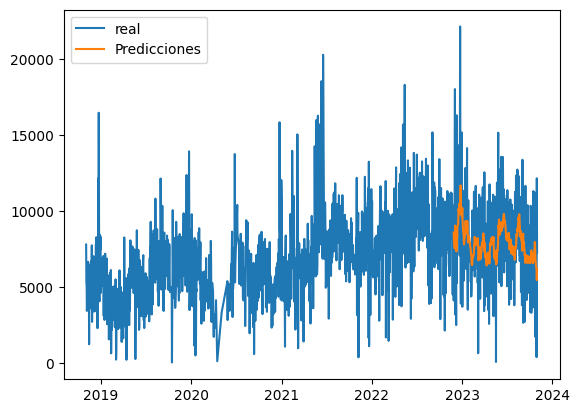

In [ ]:
# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(df_lstm['MontoBase'].values[train_size + seq_length : train_size + seq_length + len(predictions)], predictions)
print(f"Error cuadrático medio en el conjunto de prueba: {mse}")

# Visualizar las predicciones
plt.plot(df_lstm['MontoBase'], label='real')
plt.plot(df_lstm.index[train_size+seq_length:], predictions, label='Predicciones')
plt.legend()
plt.show()

In [ ]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (1647, 30)
Forma de y: (1647, 1)


1/1 [==============================] - 0s 38ms/step


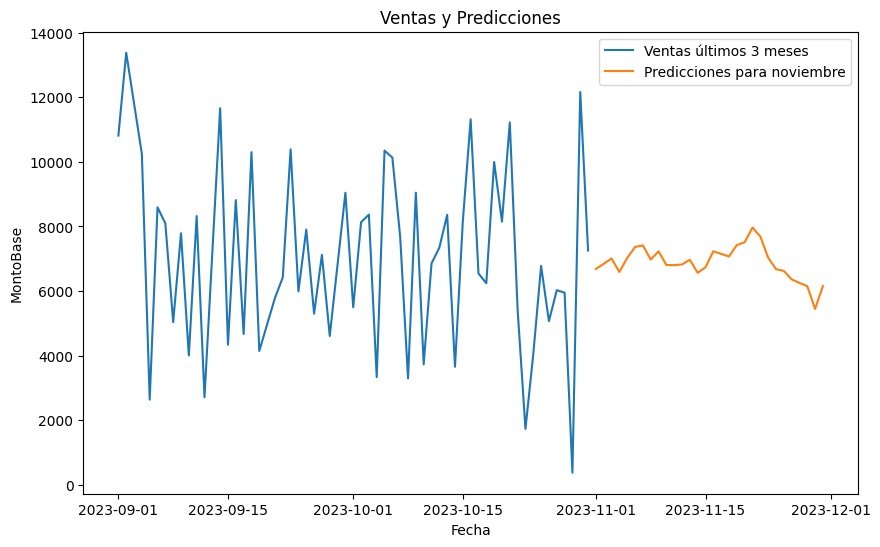

In [ ]:
# Supongamos que df_lstm tiene la columna 'FechaMovimiento' como índice
df_lstm.index = pd.to_datetime(df_lstm.index)

# Paso 1: Preparar datos de entrada para las predicciones
last_3_months = df_lstm[df_lstm.index >= '2023-09-01']  # Ajusta la fecha según tu necesidad
last_days = df_lstm.tail(60)  # Últimos 30 días

input_data = last_days['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences(input_data, seq_length)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Paso 2: Hacer predicciones para los siguientes 30 días
predictions_future = model.predict(input_data)

# Desnormalizar las predicciones
predictions_future = scaler.inverse_transform(predictions_future)

# Paso 3: Visualizar los resultados
plt.figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plt.plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
plt.plot(dates_future, predictions_future, label='Predicciones para noviembre')

plt.title('Ventas y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('MontoBase')
plt.legend()
plt.show()

In [ ]:
last_3_months.shape

(57, 5)

### Evaluar

In [ ]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_LSTM'] = predictions_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  3239.2974       6485.2545    6683.7271
1       2023-11-02  7098.1327       7188.6803    6843.6562
2       2023-11-03  4978.8291       7305.5927    7007.4731
3       2023-11-04  4431.8618       9022.4054    6590.8228
4       2023-11-05  4541.8035       6640.3463    7024.2744
5       2023-11-06  7492.0734       8092.2669    7364.3242
6       2023-11-07  7305.7163       6153.2595    7414.0166
7       2023-11-08  4343.5560       6643.6777    6974.7461
8       2023-11-09  3487.1891       7317.8101    7229.7505
9       2023-11-10  1528.0410       7402.8683    6808.6797
10      2023-11-11  7330.7520       9086.1642    6801.0068
11      2023-11-12  4889.5888       6669.8792    6823.5049
12      2023-11-13  7760.8445       8087.8522    6968.0093
13      2023-11-14  1427.7825       6116.1741    6565.4014
14      2023-11-15  1659.6720       6576.1850    6736.0767
15      2023-11-16  4789.3392       7223.1241    7231.72

In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:-
MSE is : 5932448.802811565
MAE is : 1874.8236870052087
R2 is : -0.533495739730466 %
------------------------------
RMSE is : 2435.661881873501
MAPE is : 64.77728057335744 %
------------------------------


## DESDE 2021

In [ ]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm_desde_2021 = df_lstm_desde_2021[['FechaMovimiento', 'MontoBase']]
df_lstm_desde_2021['FechaMovimiento'] = pd.to_datetime(df_lstm_desde_2021['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm_desde_2021.set_index('FechaMovimiento', inplace=True)

# Preprocesamiento de fechas utilizando el índice
df_lstm_desde_2021['DayOW'] = df_lstm_desde_2021.index.dayofweek
df_lstm_desde_2021['Month'] = df_lstm_desde_2021.index.month
df_lstm_desde_2021['Year'] = df_lstm_desde_2021.index.year

# Ordenar el DataFrame por la fecha
df_lstm_desde_2021.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm_desde_2021)

# Normalizar los datos
scaler_2 = MinMaxScaler(feature_range=(0, 1))
df_lstm_desde_2021['MontoBase_scaler'] = scaler_2.fit_transform(df_lstm_desde_2021['MontoBase'].values.reshape(-1, 1))

# Crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        #label = data[i+seq_length-1]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences(df_lstm_desde_2021['MontoBase_scaler'].values, seq_length)


# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construir el modelo LSTM
model_2 = Sequential()
model_2.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Hacer predicciones en el conjunto de prueba
predictions_2 = model_2.predict(X_test)

# Desnormalizar las predicciones
predictions_2 = scaler_2.inverse_transform(predictions_2)


                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2021-01-02      10510.9000      5      1  2021
2021-01-03       4100.4080      6      1  2021
2021-01-04       4341.8650      0      1  2021
2021-01-05       4555.7320      1      1  2021
2021-01-06       6008.0340      2      1  2021
...                    ...    ...    ...   ...
2023-10-27       6026.4036      4     10  2023
2023-10-28       5949.4542      5     10  2023
2023-10-29        374.6544      6     10  2023
2023-10-30      12163.1227      0     10  2023
2023-10-31       7254.2832      1     10  2023

[996 rows x 4 columns]
Epoch 1/50
25/25 - 2s - loss: 0.0287 - 2s/epoch - 100ms/step
Epoch 2/50
25/25 - 0s - loss: 0.0132 - 280ms/epoch - 11ms/step
Epoch 3/50
25/25 - 0s - loss: 0.0126 - 282ms/epoch - 11ms/step
Epoch 4/50
25/25 - 0s - loss: 0.0127 - 275ms/epoch - 11ms/step
Epoch 5/50
25/25 - 0s - loss: 0.0126 - 286ms/epoch - 11ms/step
Epoch 6/50
25/25 - 0s - loss: 0.0127 - 282ms/epoch -

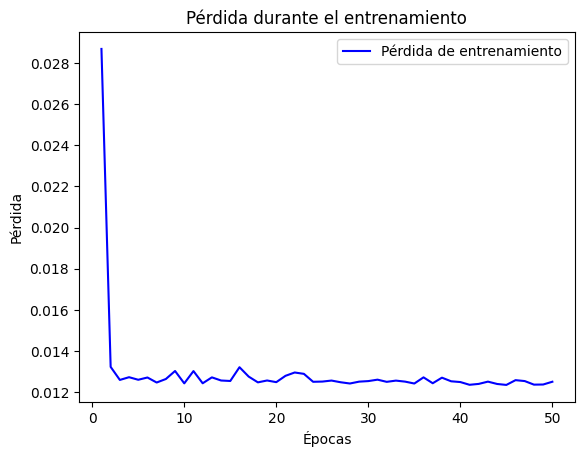

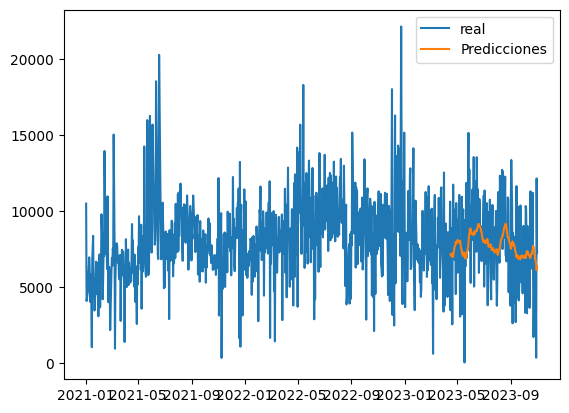

In [ ]:
# Recuperar la función de pérdida durante el entrenamiento
loss_2 = history_2.history['loss']
epochs_2 = range(1, len(loss_2) + 1)

# Graficar la pérdida durante el entrenamiento
plt.plot(epochs_2, loss_2, 'b', label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


# Visualizar las predicciones
plt.plot(df_lstm_desde_2021['MontoBase'], label='real')
plt.plot(df_lstm_desde_2021.index[train_size+seq_length:], predictions_2, label='Predicciones')
plt.legend()
plt.show()


Forma de X: (966, 30)
Forma de y: (966, 1)
1/1 [==============================] - 0s 24ms/step


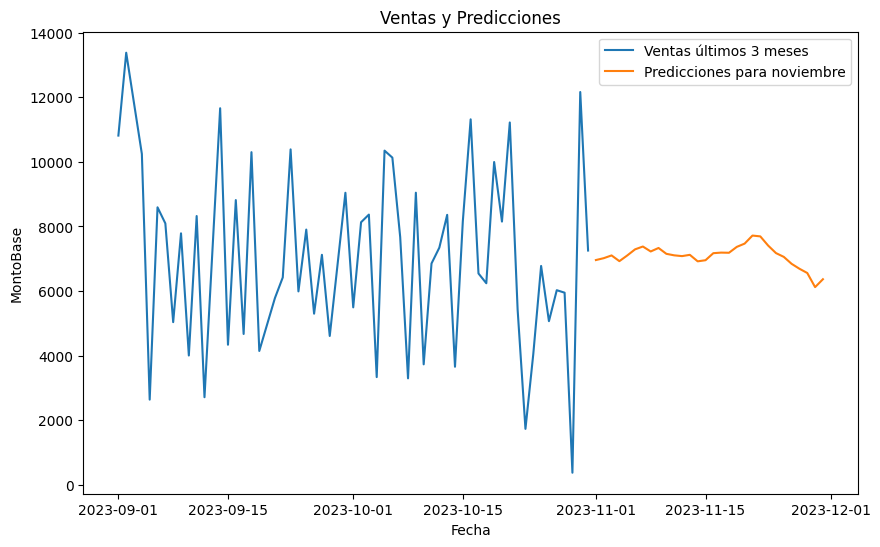

In [ ]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

# Supongamos que df_lstm_desde_2021 tiene la columna 'FechaMovimiento' como índice
df_lstm_desde_2021.index = pd.to_datetime(df_lstm_desde_2021.index)

# Paso 1: Preparar datos de entrada para las predicciones
last_3_months = df_lstm[df_lstm.index >= '2023-09-01']  # Ajusta la fecha según tu necesidad
last_days = df_lstm.tail(60)  # Últimos 30 días

input_data = last_days['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences(input_data, seq_length)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Paso 2: Hacer predicciones para los siguientes 30 días
predictions_2_future = model_2.predict(input_data)

# Desnormalizar las predicciones
predictions_2_future = scaler.inverse_transform(predictions_2_future)

# Paso 3: Visualizar los resultados
plt.figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plt.plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_2_future))
plt.plot(dates_future, predictions_2_future, label='Predicciones para noviembre')

plt.title('Ventas y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('MontoBase')
plt.legend()
plt.show()

### Evaluar

In [ ]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_desde_2021['Ventas_LSTM'] = predictions_2_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  3239.2974       6485.2545    6683.7271
1       2023-11-02  7098.1327       7188.6803    6843.6562
2       2023-11-03  4978.8291       7305.5927    7007.4731
3       2023-11-04  4431.8618       9022.4054    6590.8228
4       2023-11-05  4541.8035       6640.3463    7024.2744
5       2023-11-06  7492.0734       8092.2669    7364.3242
6       2023-11-07  7305.7163       6153.2595    7414.0166
7       2023-11-08  4343.5560       6643.6777    6974.7461
8       2023-11-09  3487.1891       7317.8101    7229.7505
9       2023-11-10  1528.0410       7402.8683    6808.6797
10      2023-11-11  7330.7520       9086.1642    6801.0068
11      2023-11-12  4889.5888       6669.8792    6823.5049
12      2023-11-13  7760.8445       8087.8522    6968.0093
13      2023-11-14  1427.7825       6116.1741    6565.4014
14      2023-11-15  1659.6720       6576.1850    6736.0767
15      2023-11-16  4789.3392       7223.1241    7231.72

In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:-
MSE is : 5932448.802811565
MAE is : 1874.8236870052087
R2 is : -0.533495739730466 %
------------------------------
RMSE is : 2435.661881873501
MAPE is : 64.77728057335744 %
------------------------------


# ARIMA

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
df_todo_hasta_nov_prophet.head()

,ds,y
0,2018-11-03,7795.8660
1,2018-11-04,5278.5900
2,2018-11-05,5096.8520
3,2018-11-06,3420.9820
4,2018-11-07,3968.6880


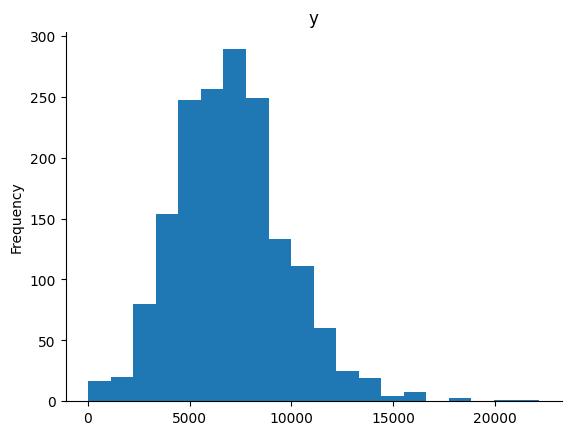

In [ ]:
# @title y

from matplotlib import pyplot as plt
df_todo_hasta_nov_prophet['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

## CON 2020

In [ ]:
df_arima = df_todo_hasta_nov_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })


# Establecer la columna 'FechaMovimiento' como índice
df_arima.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

print(df_arima.dtypes)
print(df_arima.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2018-11-03       7795.8660
2018-11-04       5278.5900
2018-11-05       5096.8520
2018-11-06       3420.9820
2018-11-07       3968.6880
...                    ...
2023-10-27       6026.4036
2023-10-28       5949.4542
2023-10-29        374.6544
2023-10-30      12163.1227
2023-10-31       7254.2832

[1677 rows x 1 columns]>


In [ ]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1677 entries, 2018-11-03 to 2023-10-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MontoBase  1677 non-null   float64
dtypes: float64(1)
memory usage: 26.2+ KB


### Identificar si los datos son estacionarios o no


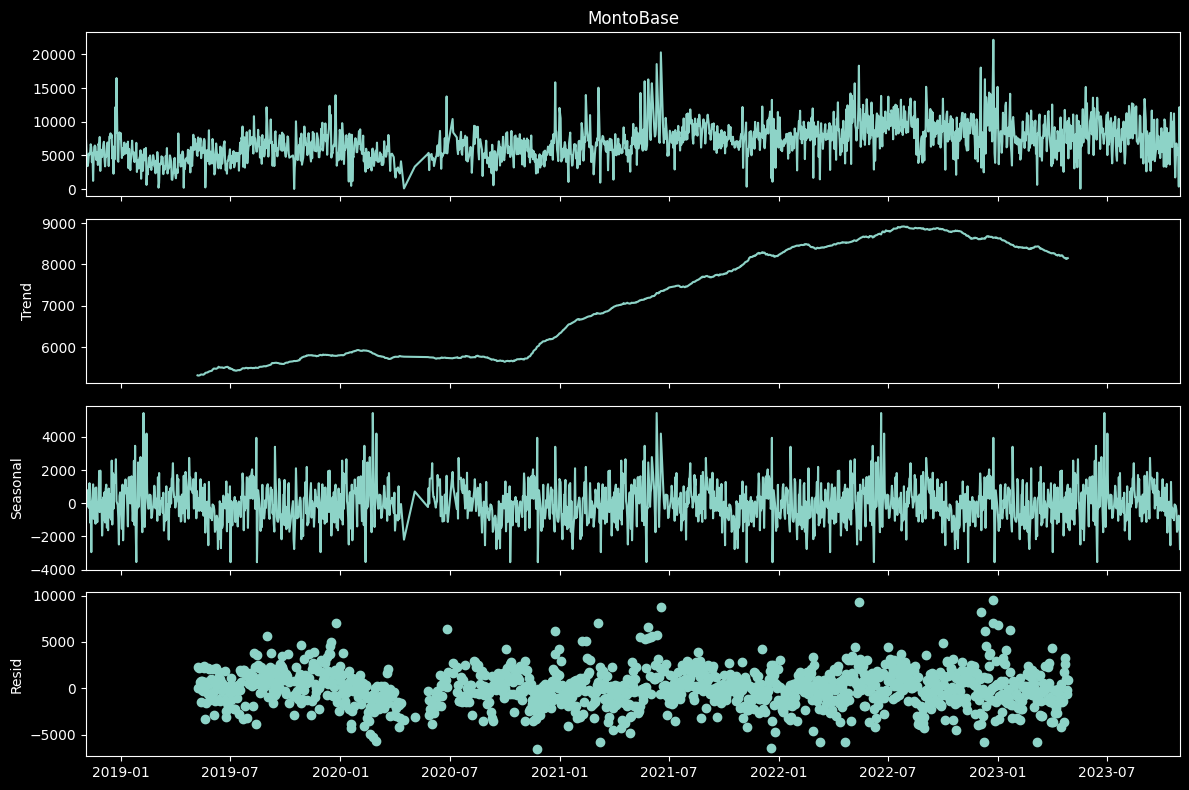

In [ ]:
#plt.style.use('seaborn')
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima["MontoBase"], model = "add", period=365)
a.plot();

In [ ]:
df_arima

,MontoBase
FechaMovimiento,
2018-11-03,7795.8660
2018-11-04,5278.5900
2018-11-05,5096.8520
2018-11-06,3420.9820
2018-11-07,3968.6880
...,...
2023-10-27,6026.4036
2023-10-28,5949.4542
2023-10-29,374.6544


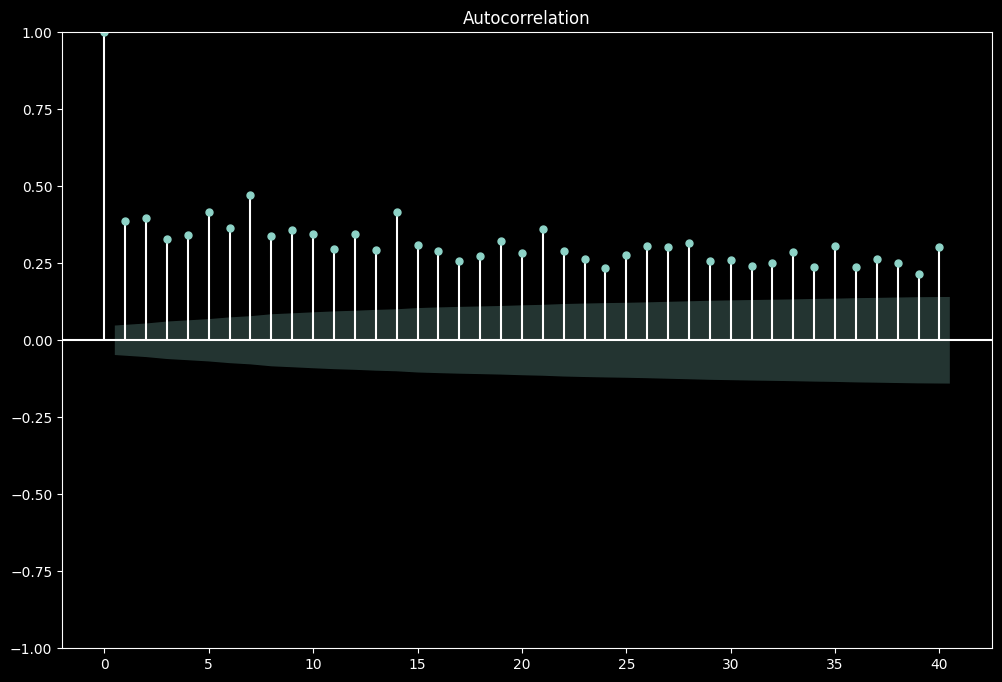

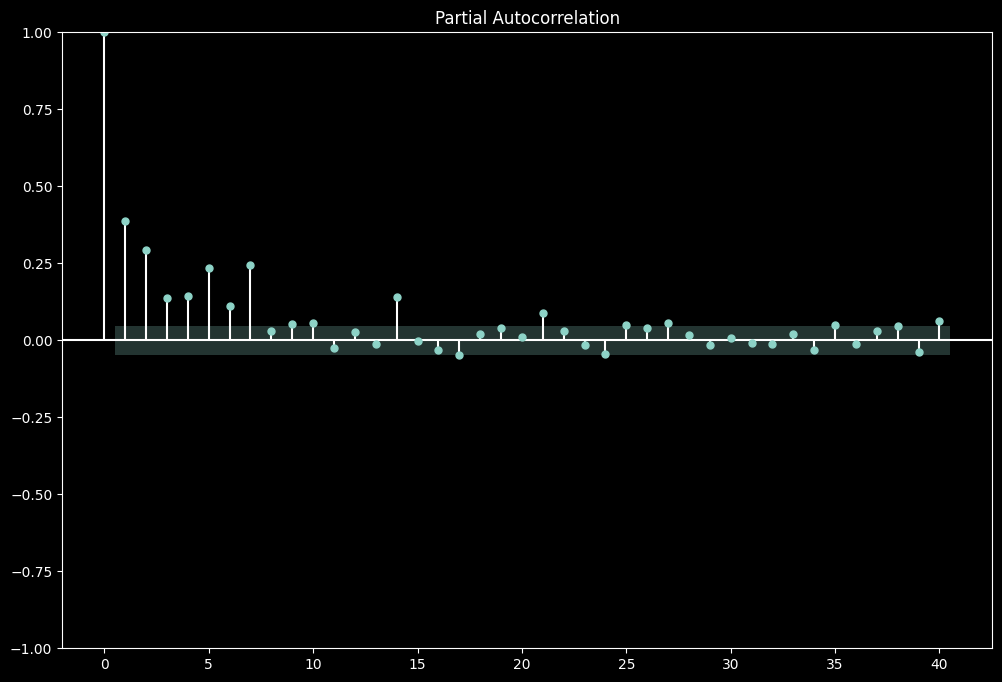

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# Dejar la columna 'FechaMovimiento' como tipo fecha
df_arima=df_arima.reset_index()

# Convertir 'FechaMovimiento' a tipo datetime si aún no lo has hecho
df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_arima.set_index('FechaMovimiento', inplace=True)

# Visualizar ACF y PACF
plt.style.use('dark_background')
plot_acf(df_arima['MontoBase'], lags=40)
plt.show()

plot_pacf(df_arima['MontoBase'], lags=40)
plt.show()

### prueba de Dickey-Fuller

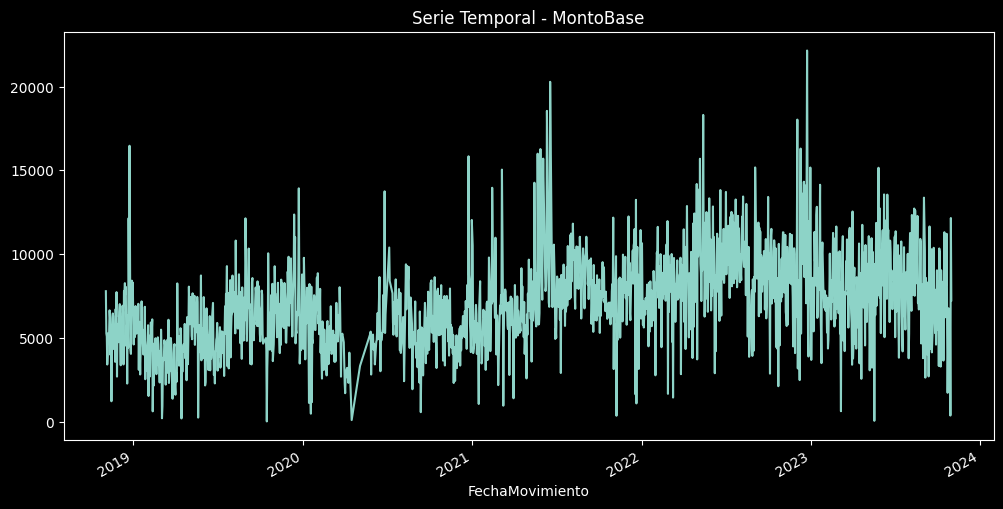

count    1677.0000
mean     7047.6205
std      2735.9453
min        24.9200
25%      5196.4430
50%      6932.6639
75%      8593.5997
max     22160.3236
Name: MontoBase, dtype: float64
Estadística de la prueba de Dickey-Fuller: -3.3626745821449524
P-valor: 0.012299040840725223
Valores críticos: {'1%': -3.4343169874697574, '5%': -2.863292198180267, '10%': -2.567702829432523}


In [ ]:
# 1. Visualización de la Serie Temporal
df_arima['MontoBase'].plot(figsize=(12, 6))
plt.title('Serie Temporal - MontoBase')
plt.show()

# 2. Estadísticas Descriptivas
print(df_arima['MontoBase'].describe())

# 3. Prueba de Dickey-Fuller
result = adfuller(df_arima['MontoBase'])
print(f'Estadística de la prueba de Dickey-Fuller: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos: {result[4]}')

In [ ]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [ ]:
Prueba_Dickey_Fuller(df_arima["MontoBase"],"MontoBase")

Resultados de la prueba de Dickey-Fuller para columna: MontoBase
Test Statistic                         -3.3627
p-value                                 0.0123
No Lags Used                           25.0000
Número de observaciones utilizadas   1651.0000
Critical Value (1%)                    -3.4343
Critical Value (5%)                    -2.8633
Critical Value (10%)                   -2.5677
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


### Dividir en train y test

In [ ]:
# # dividir en orden cronologico, un 80% para entrenamiento
# train_size = int(len(df_arima) * 0.8)
# train, test = df_arima[0:train_size], df_arima[train_size:]


# dividir en orden cronologico, entrenando sin el mes de octubre
train_size = int(len(df_arima) - 31)
train, test = df_arima[0:train_size], df_arima[train_size:]

# Divide los datos en entrenamiento y prueba
# # Asegúrate de tener una columna de fecha (DatetimeIndex) en tu DataFrame
# y = df_arima['MontoBase']

# # Especifica el tamaño del conjunto de entrenamiento
# train_size = len(y) - 30

# # Divide los datos en entrenamiento y prueba
# train, test = train_test_split(y, train_size=train_size)


In [ ]:
train.shape, test.shape

((1646, 1), (31, 1))

### más pruebas


In [ ]:
display(df_arima.head(10))
#df_arima = df_arima.set_index('FechaMovimiento')
df_arima = df_arima.asfreq('D')
display(df_arima.head(10))
#df_arima = df_arima.asfreq(None)

,MontoBase
FechaMovimiento,
2018-11-03,7795.8660
2018-11-04,5278.5900
2018-11-05,5096.8520
2018-11-06,3420.9820
2018-11-07,3968.6880
2018-11-08,5289.6260
2018-11-09,5115.4530
2018-11-10,5351.4810
2018-11-11,6655.2420


,MontoBase
FechaMovimiento,
2018-11-03,7795.8660
2018-11-04,5278.5900
2018-11-05,5096.8520
2018-11-06,3420.9820
2018-11-07,3968.6880
2018-11-08,5289.6260
2018-11-09,5115.4530
2018-11-10,5351.4810
2018-11-11,6655.2420


In [ ]:
print(df_arima.isnull().sum())

MontoBase    147
dtype: int64


In [ ]:
df_arima = df_arima.dropna()

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -3.3626745821449524, p-value: 0.012299040840725223
KPSS Statistic: 4.065508579022337, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -11.870812310114871, p-value: 6.51032623667429e-22
KPSS Statistic: 0.021602552323754992, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -15.026332611428217, p-value: 1.0051513211365497e-27
KPSS Statistic: 0.01054845810137308, p-value: 0.1


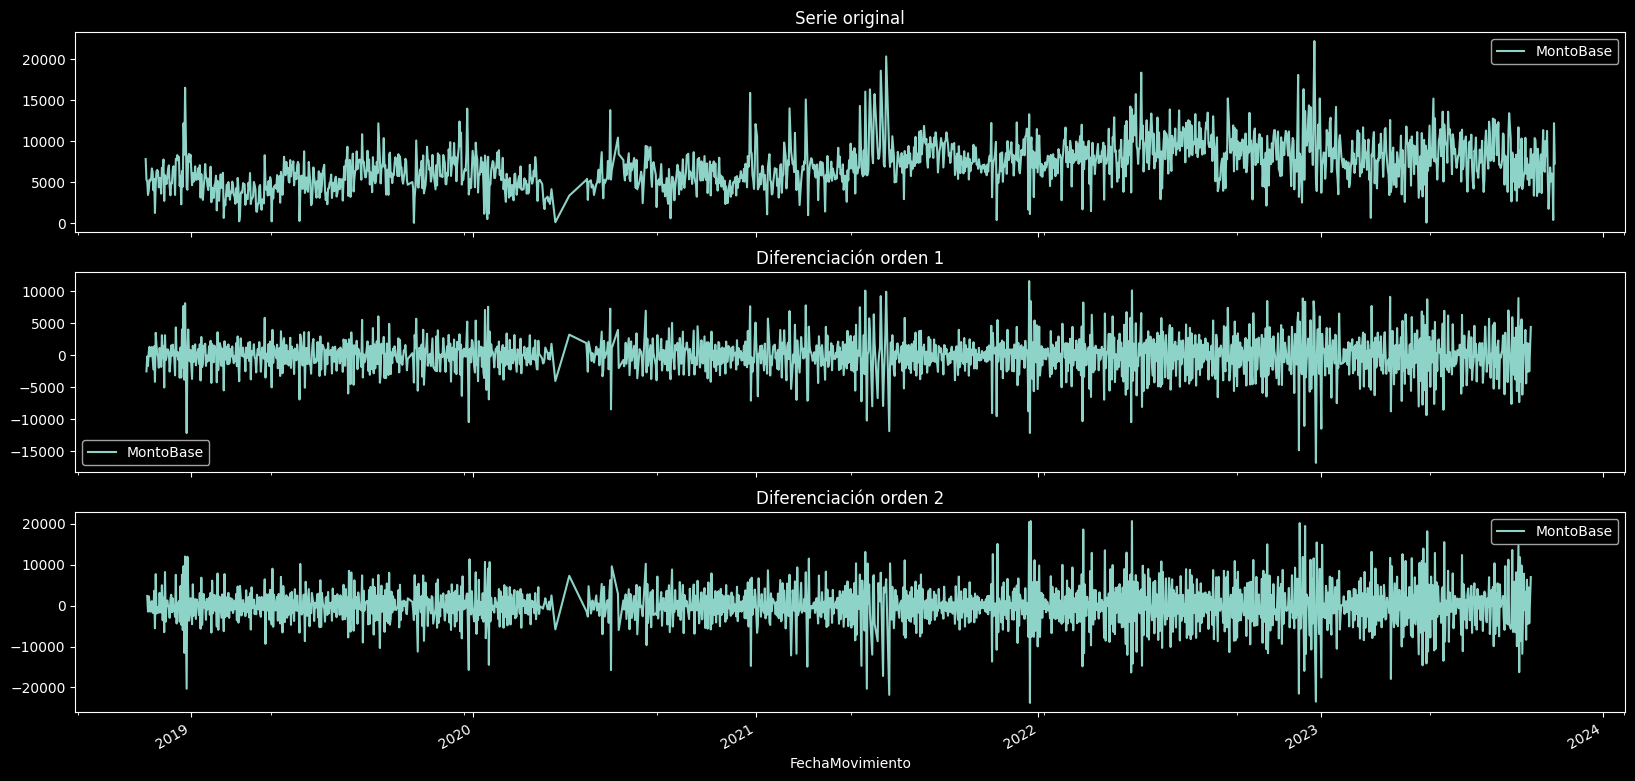

In [ ]:

from statsmodels.tsa.stattools import kpss
import warnings
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

df_arima_diff_1 = train.diff().dropna()
df_arima_diff_2 = df_arima_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(df_arima)
kpss_result = kpss(df_arima)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_1)
kpss_result = kpss(df_arima.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_2)
kpss_result = kpss(df_arima.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)
df_arima.plot(ax=axs[0], title='Serie original')
df_arima_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
df_arima_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


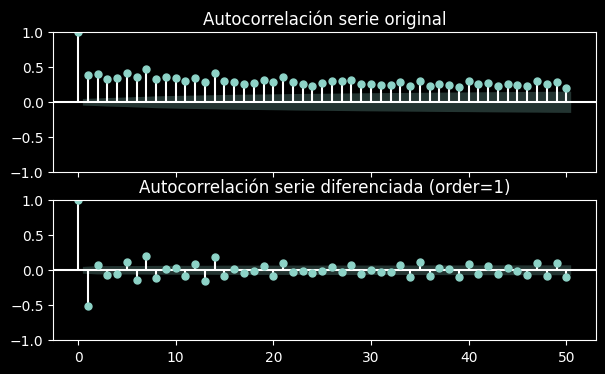

In [ ]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

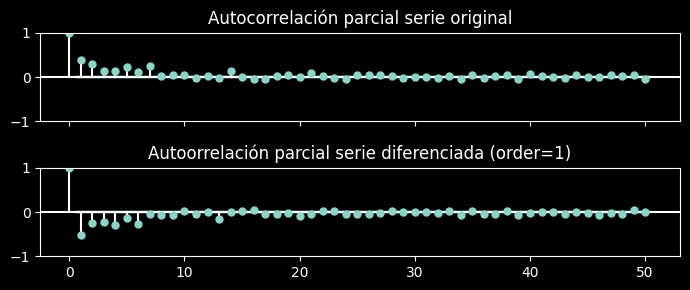

In [ ]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

In [ ]:
# # Asegurarse de que df_arima sea una serie temporal y no un DataFrame
# #df_arima = df_arima['MontoBase']

# # Descomposición de la serie original
# res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq', period=365)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # Descomposición de la serie original y la serie diferenciada
# # ==============================================================================
# #res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq')

# res_descompose_diff_2 = seasonal_decompose(df_arima_diff_1, model='additive', extrapolate_trend='freq', period=365)

# fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
# res_decompose.observed.plot(ax=axs[0, 0])
# axs[0, 0].set_title('Serie original')
# res_decompose.trend.plot(ax=axs[1, 0])
# axs[1, 0].set_title('Tendencia')
# res_decompose.seasonal.plot(ax=axs[2, 0])
# axs[2, 0].set_title('Estacionalidad')
# res_decompose.resid.plot(ax=axs[3, 0])
# axs[3, 0].set_title('Residuos')
# res_descompose_diff_2.observed.plot(ax=axs[0, 1])
# axs[0, 1].set_title('Series diferenciadas (order=1)')
# res_descompose_diff_2.trend.plot(ax=axs[1, 1])
# axs[1, 1].set_title('Tendencia')
# res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
# axs[2, 1].set_title('Estacionalidad')
# res_descompose_diff_2.resid.plot(ax=axs[3, 1])
# axs[3, 1].set_title('Residuos')
# fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
# fig.tight_layout();

In [ ]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
df_arima_diff_1_12 = train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(df_arima_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(df_arima_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -13.157883419781884, p-value: 1.3257347664818056e-24
KPSS Statistic: 0.10472210823993022, p-value: 0.1


### auto_arima


In [ ]:
# Modelo Auto-Arima
from pmdarima import auto_arima

In [ ]:
# posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
modelo_auto=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)
# ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=31779.304, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=31057.466, Time=3.80 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.79 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=31446.409, Time=0.31 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=30949.600, Time=4.33 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=23.44 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=7.02 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=31310.197, Time=2.05 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=30737.300, Time=15.90 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=30990.992, Time=2.13 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=35.87 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=9.17 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=30734.333, Time=6.25 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=30883.657, Time=2.17 sec
 ARIMA(3,1,0)(2,1,1)[12]        

In [ ]:
print(modelo_auto.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1646
Model:             SARIMAX(4, 1, 1)x(2, 1, [], 12)   Log Likelihood              -15174.483
Date:                             Fri, 01 Mar 2024   AIC                          30364.965
Time:                                     04:46:37   BIC                          30408.151
Sample:                                          0   HQIC                         30380.985
                                            - 1646                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1345      0.031     -4.310      0.000      -0.196      -0.073
ar.L2         -0.0917      

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### implementación del modelo

In [ ]:
print(train)

                 MontoBase
FechaMovimiento           
2018-11-03       7795.8660
2018-11-04       5278.5900
2018-11-05       5096.8520
2018-11-06       3420.9820
2018-11-07       3968.6880
...                    ...
2023-09-25       7903.3513
2023-09-26       5299.5940
2023-09-27       7122.2784
2023-09-28       4609.1587
2023-09-30       9043.4235

[1646 rows x 1 columns]


In [ ]:
# plt.style.use('seaborn')
# modelo_auto.plot_diagnostics(figsize=(20,8))
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
arima_model = SARIMAX(train["MontoBase"], order = (4,1,1), seasonal_order = (2,1,0,12))
arima_result = arima_model.fit()
warnings.filterwarnings("default")
arima_result.summary()

/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduc

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           MontoBase   No. Observations:                 1646
Model:             SARIMAX(4, 1, 1)x(2, 1, [], 12)   Log Likelihood              -15174.483
Date:                             Fri, 01 Mar 2024   AIC                          30364.965
Time:                                     05:36:35   BIC                          30408.151
Sample:                                          0   HQIC                         30380.985
                                            - 1646                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1345      0.031     -4.310      0.000      -0.196      -0.073
ar.L2         -0.0917      0.027     -3.344      0.001      -0.146      -0.038
ar.L3         -0.1841      0.025     -7.281      0.000      -0.234      -0.135
ar.L4         -0.1576      0.026     -5.997      0.000      -0.209      -0.106
ma.L1         -0.7449      0.027    -27.899      0.000      -0.797      -0.693
ar.S.L12      -0.6413      0.019    -33.814      0.000      -0.678      -0.604
ar.S.L24      -0.3388      0.024    -14.257      0.000      -0.385      -0.292
sigma2      6.888e+06   1.91e+05     35.972      0.000    6.51e+06    7.26e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               107.39
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Cómo interpretar las gráficas de residuos en el modelo ARIMA


In [ ]:
arima_pred = arima_result.predict(start = len(train), end = len(df_arima)-1, typ="levels").rename("ARIMA_Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ty

1646   5826.5784
1647   5742.1146
1648   5308.8271
1649   6627.4922
1650   6015.9196
1651   6244.5478
1652   4780.2912
1653   6557.8382
1654   4024.5883
1655   5953.6149
1656   5210.7741
1657   9034.5378
1658   5570.6470
1659   4666.7682
1660   4665.4128
1661   5463.0347
1662   4399.7099
1663   6613.2850
1664   3477.0111
1665   6157.1069
1666   2559.8647
1667   6834.4875
1668   3326.7776
1669   7557.2989
1670   3937.0482
1671   5494.5484
1672   3277.7653
1673   4518.1939
1674   4167.5399
1675   6374.0953
1676   3316.2770
Name: ARIMA_Predictions, dtype: float64

In [ ]:
arima_pred.index = test.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred)

FechaMovimiento
2023-10-01   5826.5784
2023-10-02   5742.1146
2023-10-03   5308.8271
2023-10-04   6627.4922
2023-10-05   6015.9196
2023-10-06   6244.5478
2023-10-07   4780.2912
2023-10-08   6557.8382
2023-10-09   4024.5883
2023-10-10   5953.6149
2023-10-11   5210.7741
2023-10-12   9034.5378
2023-10-13   5570.6470
2023-10-14   4666.7682
2023-10-15   4665.4128
2023-10-16   5463.0347
2023-10-17   4399.7099
2023-10-18   6613.2850
2023-10-19   3477.0111
2023-10-20   6157.1069
2023-10-21   2559.8647
2023-10-22   6834.4875
2023-10-23   3326.7776
2023-10-24   7557.2989
2023-10-25   3937.0482
2023-10-26   5494.5484
2023-10-27   3277.7653
2023-10-28   4518.1939
2023-10-29   4167.5399
2023-10-30   6374.0953
2023-10-31   3316.2770
Name: ARIMA_Predictions, dtype: float64


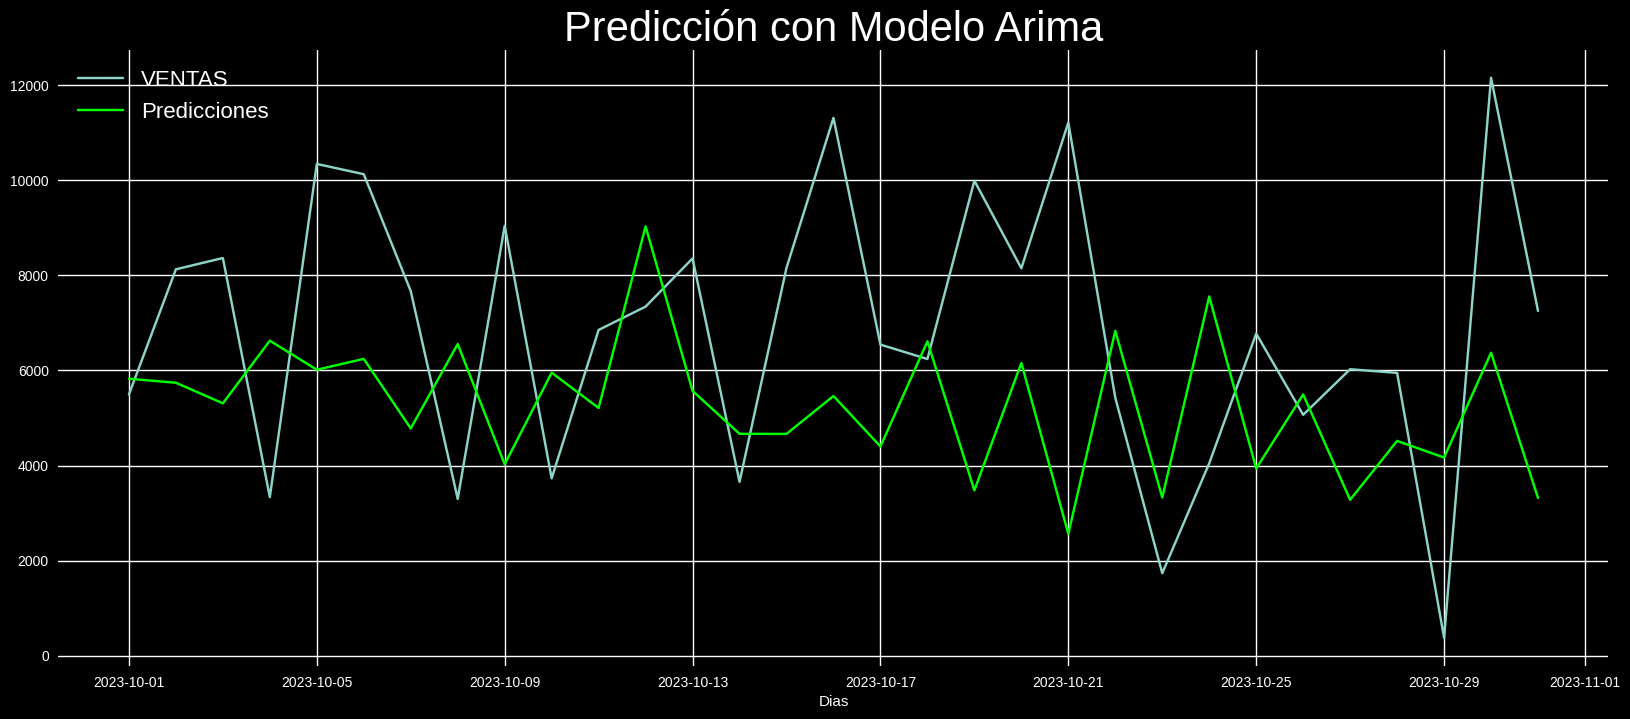

In [ ]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test["MontoBase"], label="VENTAS")
plt.plot(arima_pred, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Dias')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [ ]:
arima_pred2 = arima_result.predict(start = 1699,end=1728, typ="levels").rename("ARIMA Predictions")
arima_pred2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ty

1699   4554.7800
1700   1655.5518
1701   3996.3329
1702    812.2860
1703   4137.7730
1704   1471.9519
1705   5629.7523
1706   2107.8235
1707   2805.3336
1708   1407.2480
1709   2547.5403
1710   1979.2161
1711   3898.6159
1712   1053.8090
1713   3281.4761
1714    236.0005
1715   3240.8549
1716    843.2733
1717   4981.8701
1718   1495.2020
1719   1910.1328
1720    784.0763
1721   1895.1549
1722   1257.4259
1723   3062.8924
1724    304.3311
1725   2551.1666
1726   -521.0063
1727   2554.5931
1728    159.7263
Name: ARIMA Predictions, dtype: float64

In [ ]:
print(df_noviembre_sumaT.head())
#df_noviembre_sumaT.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_sumaT.head())

  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0      2023-11-01  3239.2974       6485.2545    6683.7271     8709.6479
1      2023-11-02  7098.1327       7188.6803    6843.6562     5804.7530
2      2023-11-03  4978.8291       7305.5927    7007.4731     8090.5133
3      2023-11-04  4431.8618       9022.4054    6590.8228     4996.2730
4      2023-11-05  4541.8035       6640.3463    7024.2744     8156.2714
  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0      2023-11-01  3239.2974       6485.2545    6683.7271     8709.6479
1      2023-11-02  7098.1327       7188.6803    6843.6562     5804.7530
2      2023-11-03  4978.8291       7305.5927    7007.4731     8090.5133
3      2023-11-04  4431.8618       9022.4054    6590.8228     4996.2730
4      2023-11-05  4541.8035       6640.3463    7024.2744     8156.2714


In [ ]:
arima_pred2.index = df_noviembre_sumaT.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred2)

0    4554.7800
1    1655.5518
2    3996.3329
3     812.2860
4    4137.7730
5    1471.9519
6    5629.7523
7    2107.8235
8    2805.3336
9    1407.2480
10   2547.5403
11   1979.2161
12   3898.6159
13   1053.8090
14   3281.4761
15    236.0005
16   3240.8549
17    843.2733
18   4981.8701
19   1495.2020
20   1910.1328
21    784.0763
22   1895.1549
23   1257.4259
24   3062.8924
25    304.3311
26   2551.1666
27   -521.0063
28   2554.5931
29    159.7263
Name: ARIMA Predictions, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<ipython-input-346-2a97b7cdadf6>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


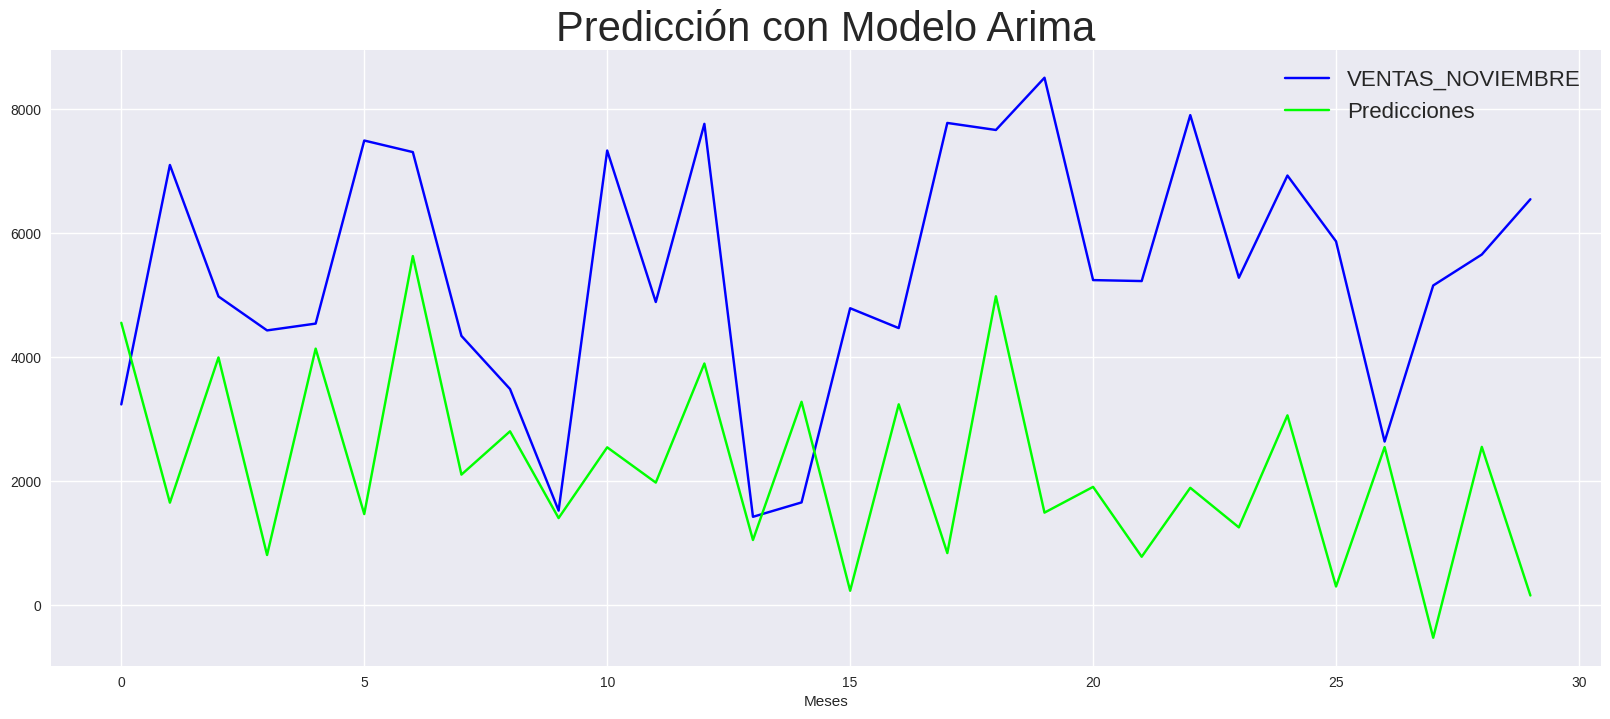

In [ ]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

#plt.plot(test["MontoBase"],color="blue" ,label="VENTAS")
plt.plot(df_noviembre_sumaT["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plt.plot(arima_pred2, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Evaluar


In [ ]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_ARIMA'] = arima_pred2

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0       2023-11-01  3239.2974       6485.2545    6683.7271     4554.7800
1       2023-11-02  7098.1327       7188.6803    6843.6562     1655.5518
2       2023-11-03  4978.8291       7305.5927    7007.4731     3996.3329
3       2023-11-04  4431.8618       9022.4054    6590.8228      812.2860
4       2023-11-05  4541.8035       6640.3463    7024.2744     4137.7730
5       2023-11-06  7492.0734       8092.2669    7364.3242     1471.9519
6       2023-11-07  7305.7163       6153.2595    7414.0166     5629.7523
7       2023-11-08  4343.5560       6643.6777    6974.7461     2107.8235
8       2023-11-09  3487.1891       7317.8101    7229.7505     2805.3336
9       2023-11-10  1528.0410       7402.8683    6808.6797     1407.2480
10      2023-11-11  7330.7520       9086.1642    6801.0068     2547.5403
11      2023-11-12  4889.5888       6669.8792    6823.5049     1979.2161
12      2023-11-13  7760.8445       8087.8522    69

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])

Evaluation metric results:-
MSE is : 15912912.265482271
MAE is : 3364.661977407369
R2 is : -3.113374422086326 %
------------------------------
RMSE is : 3989.099179699882
MAPE is : 58.48692713786334 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Desde el 2021

In [ ]:
df_arima_desde_2021 = df_todo_hasta_nov_desde_2021_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })


# Establecer la columna 'FechaMovimiento' como índice
df_arima_desde_2021.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

print(df_arima_desde_2021.dtypes)
print(df_arima_desde_2021.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2021-01-02      10510.9000
2021-01-03       4100.4080
2021-01-04       4341.8650
2021-01-05       4555.7320
2021-01-06       6008.0340
...                    ...
2023-10-27       6026.4036
2023-10-28       5949.4542
2023-10-29        374.6544
2023-10-30      12163.1227
2023-10-31       7254.2832

[996 rows x 1 columns]>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


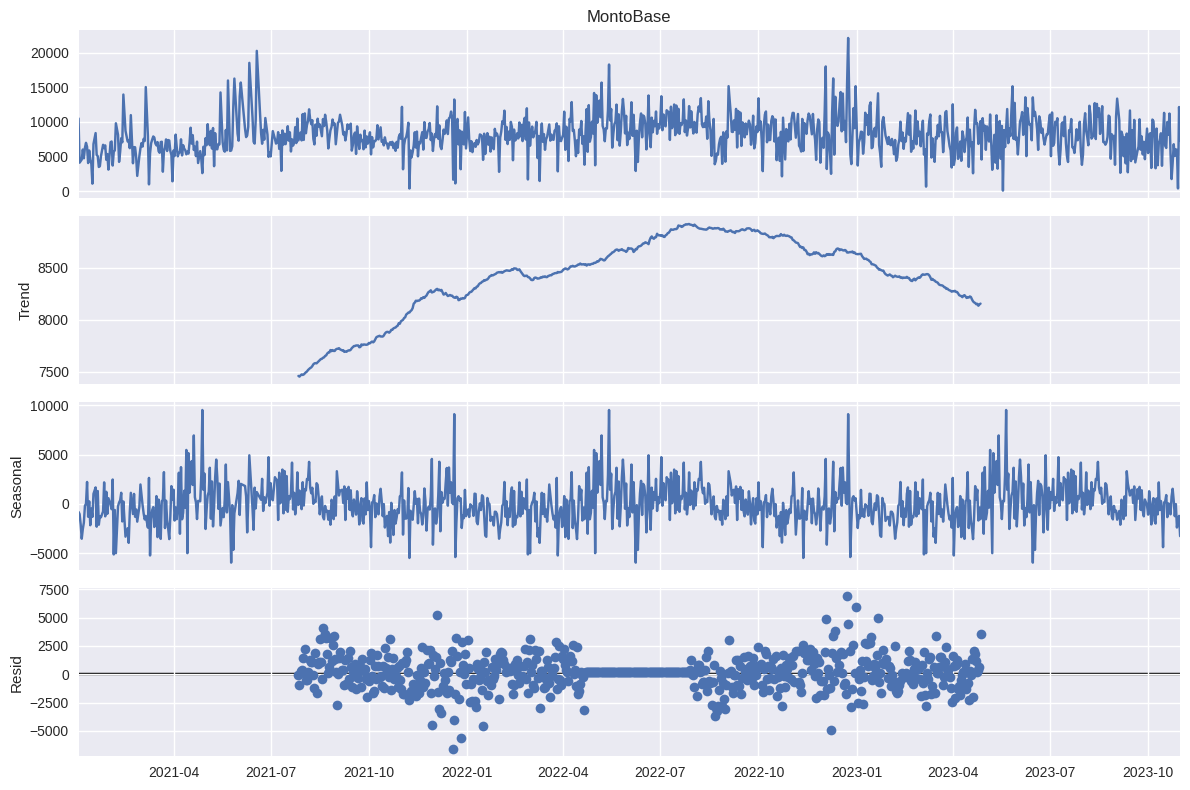

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima_desde_2021["MontoBase"], model = "add", period=365)
a.plot();

In [ ]:
# dividir en orden cronologico, entrenando sin el mes de octubre
train_size_d21 = int(len(df_arima_desde_2021) - 31)
train_d21, test_d21 = df_arima_desde_2021[0:train_size_d21], df_arima_desde_2021[train_size_d21:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_d21.shape, test_d21.shape

((965, 1), (31, 1))

In [ ]:
print(train_d21)

                 MontoBase
FechaMovimiento           
2021-01-02      10510.9000
2021-01-03       4100.4080
2021-01-04       4341.8650
2021-01-05       4555.7320
2021-01-06       6008.0340
...                    ...
2023-09-25       7903.3513
2023-09-26       5299.5940
2023-09-27       7122.2784
2023-09-28       4609.1587
2023-09-30       9043.4235

[965 rows x 1 columns]


In [ ]:
# posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
modelo_auto=auto_arima(train_d21,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)
# ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18767.322, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=18364.754, Time=0.78 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=18573.681, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=18274.768, Time=2.21 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=19.62 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.72 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=18503.530, Time=1.14 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=18198.903, Time=2.97 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=18301.037, Time=1.24 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=19.04 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.90 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=18137.577, Time=3.47 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=18229.621, Time=1.89 sec
 ARIMA(3,1,0)(2,1,1)[12]         

In [ ]:
print(modelo_auto.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  965
Model:             SARIMAX(4, 1, 2)x(2, 1, [], 12)   Log Likelihood               -8935.623
Date:                             Fri, 01 Mar 2024   AIC                          17889.246
Time:                                     05:45:21   BIC                          17932.973
Sample:                                          0   HQIC                         17905.905
                                             - 965                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7992      0.089     -8.943      0.000      -0.974      -0.624
ar.L2         -0.1473      

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (4,1,2), seasonal_order = (2,1,0,12))
arima_result_d21 = arima_model_d21.fit()
arima_result_d21.summary()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           MontoBase   No. Observations:                  965
Model:             SARIMAX(4, 1, 2)x(2, 1, [], 12)   Log Likelihood               -8935.623
Date:                             Fri, 01 Mar 2024   AIC                          17889.246
Time:                                     05:50:27   BIC                          17932.973
Sample:                                          0   HQIC                         17905.905
                                             - 965                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7992      0.089     -8.943      0.000      -0.974      -0.624
ar.L2         -0.1473      0.049     -3.019      0.003      -0.243      -0.052
ar.L3         -0.2158      0.045     -4.844      0.000      -0.303      -0.129
ar.L4         -0.2523      0.031     -8.210      0.000      -0.312      -0.192
ma.L1         -0.1150      0.088     -1.304      0.192      -0.288       0.058
ma.L2         -0.5449      0.081     -6.692      0.000      -0.704      -0.385
ar.S.L12      -0.6673      0.026    -25.205      0.000      -0.719      -0.615
ar.S.L24      -0.3632      0.033    -11.127      0.000      -0.427      -0.299
sigma2      8.293e+06   3.21e+05     25.831      0.000    7.66e+06    8.92e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                33.18
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.08e+14. Standard errors may be unstable.
"""

In [ ]:
arima_pred_d21 = arima_result_d21.predict(start = len(train_d21), end = len(df_arima_desde_2021)-2, typ="levels").rename("ARIMA_Predictions_since_2021")
arima_pred_d21
# o start = 965 , end = 994

965   6327.0854
966   5148.4559
967   5529.2586
968   6418.3370
969   6349.1311
970   5967.2271
971   4846.9877
972   6465.0569
973   3983.1942
974   5881.7180
975   5270.9419
976   9141.6711
977   5763.7255
978   4363.0012
979   4760.3759
980   5374.2429
981   4446.6850
982   6508.2775
983   3440.3163
984   6115.9854
985   2469.3360
986   6900.8495
987   3274.6631
988   7539.1473
989   4080.9481
990   5303.8064
991   3314.0547
992   4385.7721
993   4286.5841
994   6296.6647
Name: ARIMA_Predictions_since_2021, dtype: float64

In [ ]:
arima_pred_d21.index = df_noviembre_desde_2021.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred_d21)

0    6327.0854
1    5148.4559
2    5529.2586
3    6418.3370
4    6349.1311
5    5967.2271
6    4846.9877
7    6465.0569
8    3983.1942
9    5881.7180
10   5270.9419
11   9141.6711
12   5763.7255
13   4363.0012
14   4760.3759
15   5374.2429
16   4446.6850
17   6508.2775
18   3440.3163
19   6115.9854
20   2469.3360
21   6900.8495
22   3274.6631
23   7539.1473
24   4080.9481
25   5303.8064
26   3314.0547
27   4385.7721
28   4286.5841
29   6296.6647
Name: ARIMA_Predictions_since_2021, dtype: float64


  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0      2023-11-01  3239.2974       5803.8489    6959.8833   -20678.5482
1      2023-11-02  7098.1327       6328.3784    7017.7515   -17546.3316
2      2023-11-03  4978.8291       6706.0904    7103.0498   -19982.2655
3      2023-11-04  4431.8618       8452.3440    6925.9355   -15816.9152
4      2023-11-05  4541.8035       5158.0573    7101.2051   -19115.9973
  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0      2023-11-01  3239.2974       5803.8489    6959.8833   -20678.5482
1      2023-11-02  7098.1327       6328.3784    7017.7515   -17546.3316
2      2023-11-03  4978.8291       6706.0904    7103.0498   -19982.2655
3      2023-11-04  4431.8618       8452.3440    6925.9355   -15816.9152
4      2023-11-05  4541.8035       5158.0573    7101.2051   -19115.9973


<ipython-input-378-95a0eb4daed8>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


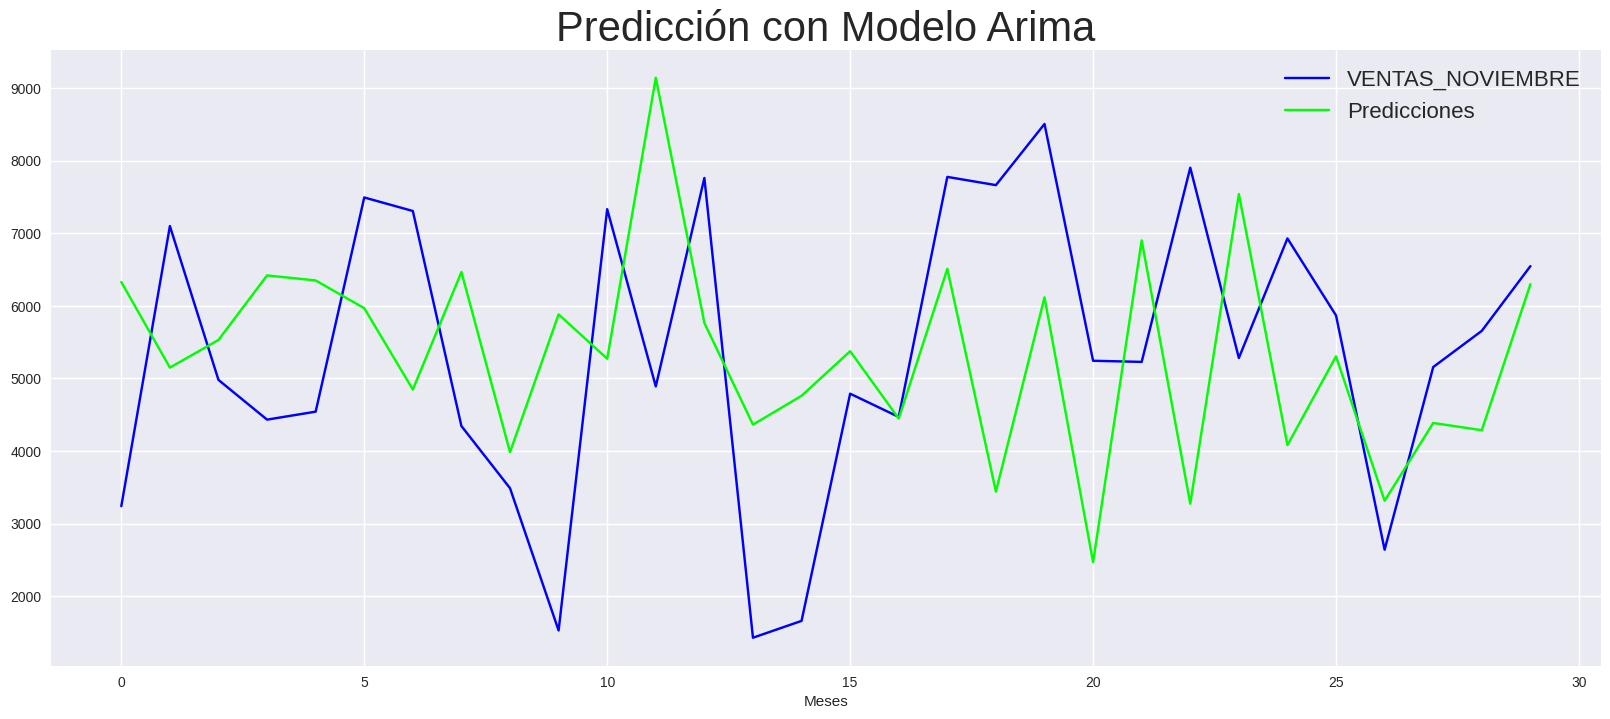

In [ ]:
print(df_noviembre_desde_2021.head())
#df_noviembre_desde_2021.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_desde_2021.head())

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)
#plt.plot(test_d21["MontoBase"],color="blue" ,label="VENTAS")
plt.plot(df_noviembre_desde_2021["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plt.plot(arima_pred_d21, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Evaluar

In [ ]:
# PARA ELIMINAR LA COLUMNA CON VALORES 'NaN'
# print(df_noviembre_desde_2021)
# df_noviembre_desde_2021.drop(columns=['Ventas_ARIMA'], inplace=True)
# print(df_noviembre_desde_2021)

In [ ]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_desde_2021['Ventas_ARIMA'] = arima_pred_d21

# Imprimir el resultado
print(df_noviembre_desde_2021.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0       2023-11-01  3239.2974       5803.8489    6959.8833     6327.0854
1       2023-11-02  7098.1327       6328.3784    7017.7515     5148.4559
2       2023-11-03  4978.8291       6706.0904    7103.0498     5529.2586
3       2023-11-04  4431.8618       8452.3440    6925.9355     6418.3370
4       2023-11-05  4541.8035       5158.0573    7101.2051     6349.1311
5       2023-11-06  7492.0734       7077.3262    7291.0767     5967.2271
6       2023-11-07  7305.7163       5095.7510    7378.9907     4846.9877
7       2023-11-08  4343.5560       5811.9786    7225.8423     6465.0569
8       2023-11-09  3487.1891       6347.2257    7333.7271     3983.1942
9       2023-11-10  1528.0410       6736.2389    7153.0376     5881.7180
10      2023-11-11  7330.7520       8494.4891    7105.9736     5270.9419
11      2023-11-12  4889.5888       5212.9944    7081.8135     9141.6711
12      2023-11-13  7760.8445       7145.9362    71

In [ ]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_ARIMA'])

Evaluation metric results:-
MSE is : 5711648.910924596
MAE is : 2032.3589653122208
R2 is : -0.4764205411411171 %
------------------------------
RMSE is : 2389.905628037349
MAPE is : 52.37502473478218 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# TODAS LAS EVALUACIONES

In [ ]:
print("--"*10,"EVALUACIÓN CON TODOS LOS DATOS","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])
print("--"*10,"EVALUACIÓN DESDE EL 2021","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_ARIMA'])

-------------------- EVALUACIÓN CON TODOS LOS DATOS --------------------
---------- PROPHET ----------
Evaluation metric results:-
MSE is : 6906389.822842958
MAE is : 2085.786700092378
R2 is : -0.7852525529134227 %
------------------------------
RMSE is : 2628.0011078466005
MAPE is : 69.07964582820276 %
------------------------------
---------- LSTM ----------
Evaluation metric results:-
MSE is : 5932448.802811565
MAE is : 1874.8236870052087
R2 is : -0.533495739730466 %
------------------------------
RMSE is : 2435.661881873501
MAPE is : 64.77728057335744 %
------------------------------
---------- ARIMA ----------
Evaluation metric results:-
MSE is : 15912912.265482271
MAE is : 3364.661977407369
R2 is : -3.113374422086326 %
------------------------------
RMSE is : 3989.099179699882
MAPE is : 58.48692713786334 %
------------------------------
-------------------- EVALUACIÓN DESDE EL 2021 --------------------
---------- PROPHET ----------
Evaluation metric results:-
MSE is : 5192538.354

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-383-0fc22ac8dbf5>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


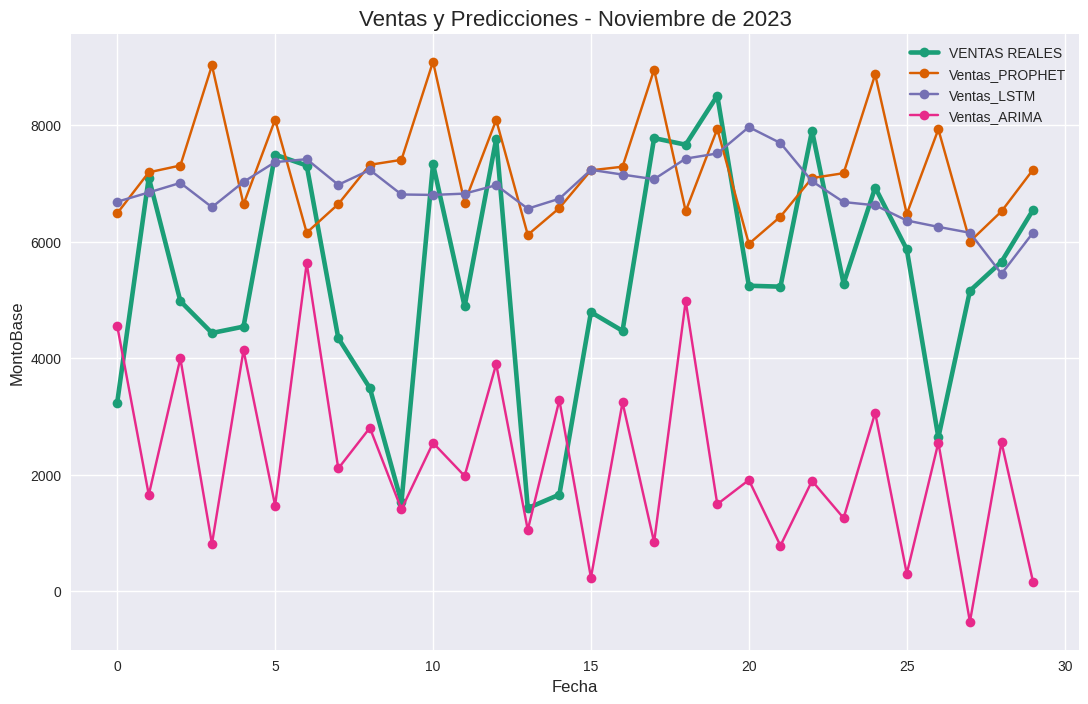

In [ ]:
# Establecer el estilo de Seaborn
plt.style.use('seaborn')
sns.set_palette("Dark2")

# Graficar los datos para df_noviembre_sumaT
plt.figure(figsize=(13, 8))
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
plt.title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('MontoBase', fontsize=12)
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-384-cf34a6a71e3f>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


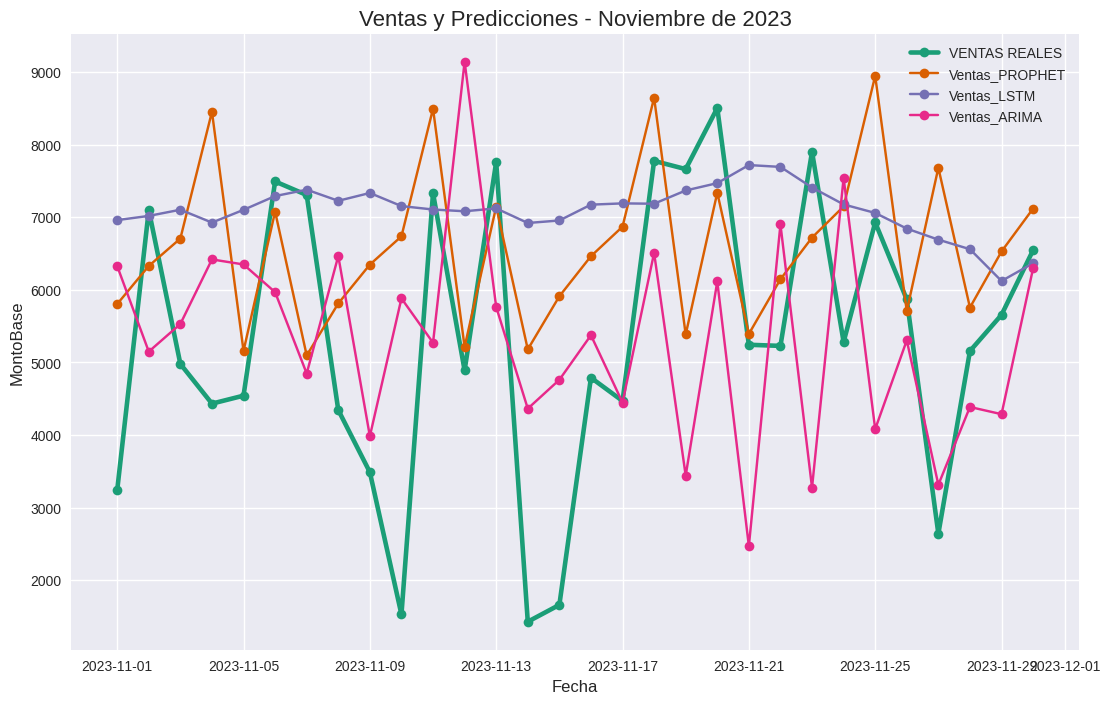

In [ ]:
# Establecer el estilo de Seaborn
plt.style.use('seaborn')
sns.set_palette("Dark2")

# Graficar los datos para df_noviembre_desde_2021
plt.figure(figsize=(13, 8))
plt.plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plt.plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plt.plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plt.plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
plt.title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('MontoBase', fontsize=12)
plt.legend()
plt.show()